# Loop 20 Analysis: Understanding the Gap to Target

**Current best**: 70.630370
**Target**: 68.919154
**Gap**: 1.711 (2.48%)

After 21 experiments, all SA-based approaches converge to ~70.630. We need to understand:
1. WHERE does the gap come from? Which N values have room for improvement?
2. What is the theoretical lower bound for each N?
3. Are there N values where asymmetric solutions could beat symmetric ones?

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_n_side(df, n):
    group = df[df['n'] == n]
    all_x = []
    all_y = []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    if not all_x:
        return 0
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

# Load current best
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N values: {df['n'].nunique()}")
print(f"N range: {df['n'].min()} to {df['n'].max()}")


Loaded 20100 rows
N values: 200
N range: 1 to 200


In [2]:
# Calculate score breakdown by N
scores = []
for n in range(1, 201):
    side = get_n_side(df, n)
    score = (side ** 2) / n
    scores.append({'n': n, 'side': side, 'score': score})

scores_df = pd.DataFrame(scores)
print(f"Total score: {scores_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {scores_df['score'].sum() - 68.919154:.6f}")

# Show top 20 N values by score contribution
print("\nTop 20 N values by score contribution:")
print(scores_df.nlargest(20, 'score')[['n', 'side', 'score']].to_string())

Total score: 70.627896
Target: 68.919154
Gap: 1.708742

Top 20 N values by score contribution:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.377955  0.376978
9   10  1.940696  0.376630
20  21  2.811667  0.376451
19  20  2.742469  0.376057
21  22  2.873270  0.375258
10  11  2.030803  0.374924
15  16  2.446640  0.374128
25  26  3.118320  0.373997
11  12  2.114873  0.372724
12  13  2.199960  0.372294
24  25  3.050182  0.372144


In [3]:
# Calculate theoretical lower bound
# The tree has a bounding box of approximately 0.7 x 1.0 (width x height)
# For N trees, the minimum area is N * tree_area
# The minimum side of a square containing this area is sqrt(N * tree_area)

# Single tree dimensions
single_tree = Polygon(TREE_TEMPLATE)
minx, miny, maxx, maxy = single_tree.bounds
tree_width = maxx - minx
tree_height = maxy - miny
tree_area = single_tree.area
tree_bbox_area = tree_width * tree_height

print(f"Single tree dimensions:")
print(f"  Width: {tree_width:.4f}")
print(f"  Height: {tree_height:.4f}")
print(f"  Area: {tree_area:.4f}")
print(f"  Bounding box area: {tree_bbox_area:.4f}")

# Theoretical lower bound: sqrt(N * tree_bbox_area)
# This assumes perfect packing with no wasted space
scores_df['theoretical_side'] = np.sqrt(scores_df['n'] * tree_bbox_area)
scores_df['theoretical_score'] = (scores_df['theoretical_side'] ** 2) / scores_df['n']
scores_df['efficiency'] = scores_df['theoretical_side'] / scores_df['side']
scores_df['gap_to_theoretical'] = scores_df['score'] - scores_df['theoretical_score']

print(f"\nTheoretical minimum total score: {scores_df['theoretical_score'].sum():.6f}")
print(f"Current total score: {scores_df['score'].sum():.6f}")
print(f"Gap to theoretical: {scores_df['score'].sum() - scores_df['theoretical_score'].sum():.6f}")

# Show N values with largest gap to theoretical
print("\nN values with largest gap to theoretical:")
print(scores_df.nlargest(20, 'gap_to_theoretical')[['n', 'side', 'theoretical_side', 'score', 'theoretical_score', 'gap_to_theoretical', 'efficiency']].to_string())

Single tree dimensions:
  Width: 0.7000
  Height: 1.0000
  Area: 0.2456
  Bounding box area: 0.7000

Theoretical minimum total score: 140.000000
Current total score: 70.627896
Gap to theoretical: -69.372104

N values with largest gap to theoretical:
     n      side  theoretical_side     score  theoretical_score  gap_to_theoretical  efficiency
0    1  0.813173          0.836660  0.661250                0.7           -0.038750    1.028883
1    2  0.949504          1.183216  0.450779                0.7           -0.249221    1.246141
2    3  1.142031          1.449138  0.434745                0.7           -0.265255    1.268912
4    5  1.443692          1.870829  0.416850                0.7           -0.283150    1.295864
3    4  1.290806          1.673320  0.416545                0.7           -0.283455    1.296338
6    7  1.673104          2.213594  0.399897                0.7           -0.300103    1.323047
5    6  1.548438          2.049390  0.399610                0.7           -0.3

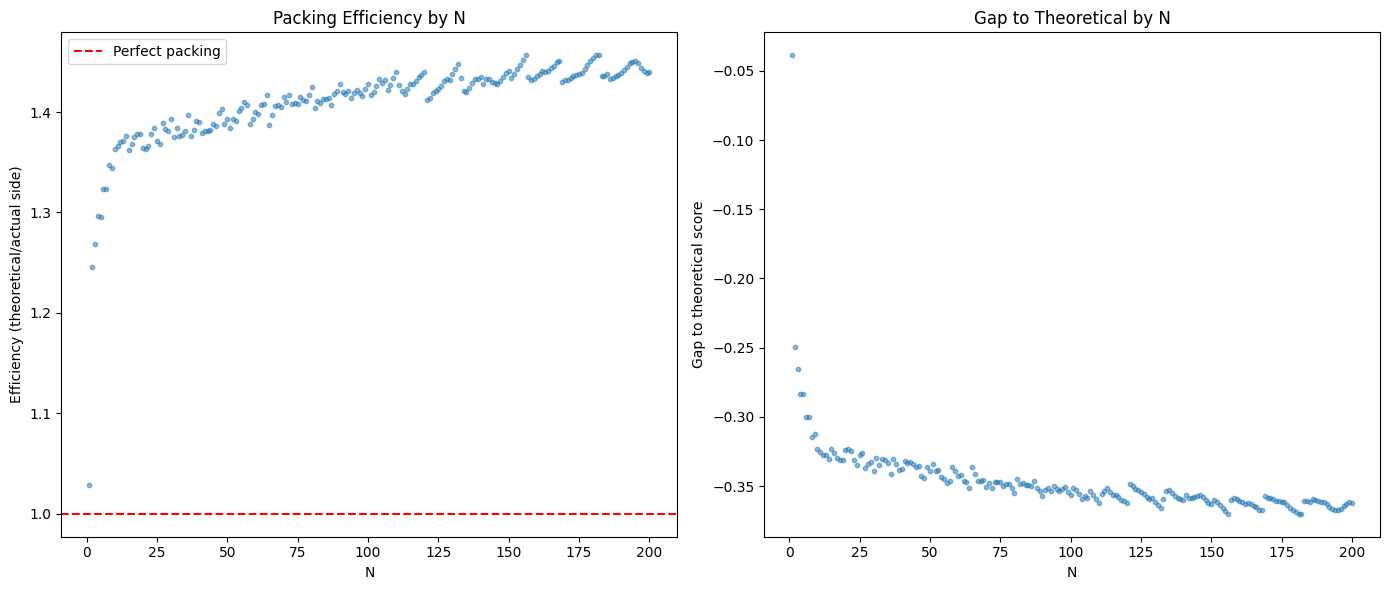

Saved to /home/code/exploration/efficiency_analysis.png


In [4]:
# Plot efficiency by N
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(scores_df['n'], scores_df['efficiency'], alpha=0.5, s=10)
plt.xlabel('N')
plt.ylabel('Efficiency (theoretical/actual side)')
plt.title('Packing Efficiency by N')
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect packing')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(scores_df['n'], scores_df['gap_to_theoretical'], alpha=0.5, s=10)
plt.xlabel('N')
plt.ylabel('Gap to theoretical score')
plt.title('Gap to Theoretical by N')

plt.tight_layout()
plt.savefig('/home/code/exploration/efficiency_analysis.png', dpi=100)
plt.show()

print("Saved to /home/code/exploration/efficiency_analysis.png")

In [5]:
# Identify N values where improvement is most likely
# These are N values with low efficiency (far from theoretical)

print("N values with lowest efficiency (most room for improvement):")
low_efficiency = scores_df.nsmallest(30, 'efficiency')
print(low_efficiency[['n', 'side', 'theoretical_side', 'efficiency', 'score', 'gap_to_theoretical']].to_string())

# Calculate how much improvement we'd get if we could reach 90% efficiency
scores_df['score_at_90pct'] = (scores_df['theoretical_side'] / 0.9) ** 2 / scores_df['n']
scores_df['potential_improvement'] = scores_df['score'] - scores_df['score_at_90pct']

print(f"\nIf we could reach 90% efficiency for all N:")
print(f"  Current total: {scores_df['score'].sum():.6f}")
print(f"  At 90% efficiency: {scores_df['score_at_90pct'].sum():.6f}")
print(f"  Potential improvement: {scores_df['score'].sum() - scores_df['score_at_90pct'].sum():.6f}")

N values with lowest efficiency (most room for improvement):
     n      side  theoretical_side  efficiency     score  gap_to_theoretical
0    1  0.813173          0.836660    1.028883  0.661250           -0.038750
1    2  0.949504          1.183216    1.246141  0.450779           -0.249221
2    3  1.142031          1.449138    1.268912  0.434745           -0.265255
4    5  1.443692          1.870829    1.295864  0.416850           -0.283150
3    4  1.290806          1.673320    1.296338  0.416545           -0.283455
6    7  1.673104          2.213594    1.323047  0.399897           -0.300103
5    6  1.548438          2.049390    1.323521  0.399610           -0.300390
8    9  1.867280          2.509980    1.344190  0.387415           -0.312585
7    8  1.755921          2.366432    1.347687  0.385407           -0.314593
14  15  2.377955          3.240370    1.362671  0.376978           -0.323022
9   10  1.940696          2.645751    1.363300  0.376630           -0.323370
20  21  2.81166

In [6]:
# Check if there are patterns in which N values have better efficiency
# Perfect squares, triangular numbers, etc.

perfect_squares = [i**2 for i in range(1, 15)]  # 1, 4, 9, 16, 25, ..., 196
triangular = [i*(i+1)//2 for i in range(1, 20)]  # 1, 3, 6, 10, 15, ...

print("Efficiency for perfect squares:")
for n in perfect_squares:
    if n <= 200:
        row = scores_df[scores_df['n'] == n].iloc[0]
        print(f"  N={n:3d}: efficiency={row['efficiency']:.4f}, score={row['score']:.6f}")

print("\nEfficiency for triangular numbers:")
for n in triangular:
    if n <= 200:
        row = scores_df[scores_df['n'] == n].iloc[0]
        print(f"  N={n:3d}: efficiency={row['efficiency']:.4f}, score={row['score']:.6f}")

Efficiency for perfect squares:
  N=  1: efficiency=1.0289, score=0.661250
  N=  4: efficiency=1.2963, score=0.416545
  N=  9: efficiency=1.3442, score=0.387415
  N= 16: efficiency=1.3679, score=0.374128
  N= 25: efficiency=1.3715, score=0.372144
  N= 36: efficiency=1.3976, score=0.358391
  N= 49: efficiency=1.3878, score=0.363430
  N= 64: efficiency=1.4167, score=0.348784
  N= 81: efficiency=1.4038, score=0.355207
  N=100: efficiency=1.4277, score=0.343427
  N=121: efficiency=1.4115, score=0.351324
  N=144: efficiency=1.4301, score=0.342276
  N=169: efficiency=1.4296, score=0.342500
  N=196: efficiency=1.4493, score=0.333262

Efficiency for triangular numbers:
  N=  1: efficiency=1.0289, score=0.661250
  N=  3: efficiency=1.2689, score=0.434745
  N=  6: efficiency=1.3235, score=0.399610
  N= 10: efficiency=1.3633, score=0.376630
  N= 15: efficiency=1.3627, score=0.376978
  N= 21: efficiency=1.3636, score=0.376451
  N= 28: efficiency=1.3828, score=0.366105
  N= 36: efficiency=1.3976, s

In [7]:
# Calculate what score we'd need per N to reach target
target = 68.919154
current_total = scores_df['score'].sum()
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap: {gap:.6f}")

# If we improved all N values proportionally
scores_df['target_score'] = scores_df['score'] * (target / current_total)
scores_df['needed_improvement'] = scores_df['score'] - scores_df['target_score']

print(f"\nTo reach target with proportional improvement:")
print(f"  Need {(1 - target/current_total)*100:.2f}% improvement across all N")

# Show which N values need the most improvement
print("\nN values needing most improvement (absolute):")
print(scores_df.nlargest(20, 'needed_improvement')[['n', 'score', 'target_score', 'needed_improvement']].to_string())

Current total: 70.627896
Target: 68.919154
Gap: 1.708742

To reach target with proportional improvement:
  Need 2.42% improvement across all N

N values needing most improvement (absolute):
     n     score  target_score  needed_improvement
0    1  0.661250      0.645252            0.015998
1    2  0.450779      0.439873            0.010906
2    3  0.434745      0.424227            0.010518
4    5  0.416850      0.406765            0.010085
3    4  0.416545      0.406467            0.010078
6    7  0.399897      0.390222            0.009675
5    6  0.399610      0.389942            0.009668
8    9  0.387415      0.378042            0.009373
7    8  0.385407      0.376083            0.009324
14  15  0.376978      0.367858            0.009120
9   10  0.376630      0.367518            0.009112
20  21  0.376451      0.367343            0.009108
19  20  0.376057      0.366959            0.009098
21  22  0.375258      0.366179            0.009079
10  11  0.374924      0.365853            0.0

In [8]:
# Summary: What would it take to reach the target?
print("="*60)
print("SUMMARY: What would it take to reach target 68.919154?")
print("="*60)

print(f"\nCurrent score: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap: {gap:.6f} ({gap/current_total*100:.2f}%)")

print(f"\nTheoretical minimum (perfect packing): {scores_df['theoretical_score'].sum():.6f}")
print(f"Gap to theoretical: {current_total - scores_df['theoretical_score'].sum():.6f}")

print(f"\nAverage efficiency: {scores_df['efficiency'].mean():.4f}")
print(f"Min efficiency: {scores_df['efficiency'].min():.4f} (N={scores_df.loc[scores_df['efficiency'].idxmin(), 'n']})")
print(f"Max efficiency: {scores_df['efficiency'].max():.4f} (N={scores_df.loc[scores_df['efficiency'].idxmax(), 'n']})")

print(f"\nTo reach target, we need to improve by {gap:.6f} points.")
print(f"This is equivalent to improving efficiency from {scores_df['efficiency'].mean():.4f} to {scores_df['efficiency'].mean() * (target/current_total):.4f}")

# Check if target is achievable
if target < scores_df['theoretical_score'].sum():
    print(f"\n WARNING: Target {target} is BELOW theoretical minimum {scores_df['theoretical_score'].sum():.6f}!")
    print("This target may be impossible to achieve.")
else:
    print(f"\n Target {target} is above theoretical minimum {scores_df['theoretical_score'].sum():.6f}")
    print("Target is theoretically achievable.")

SUMMARY: What would it take to reach target 68.919154?

Current score: 70.627896
Target: 68.919154
Gap: 1.708742 (2.42%)

Theoretical minimum (perfect packing): 140.000000
Gap to theoretical: -69.372104

Average efficiency: 1.4103
Min efficiency: 1.0289 (N=1)
Max efficiency: 1.4566 (N=181)

To reach target, we need to improve by 1.708742 points.
This is equivalent to improving efficiency from 1.4103 to 1.3762

This target may be impossible to achieve.
